In [4]:
from google.colab import files
uploaded = files.upload()


Saving movie.csv to movie.csv


First 5 rows:
                                                 text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1

Data shape: (40000, 2)

Duplicate entries: 277

Missing values:
 text     0
label    0
dtype: int64

Sentiment unique values: [0 1]

Value counts:
 label
1    19908
0    19815
Name: count, dtype: int64


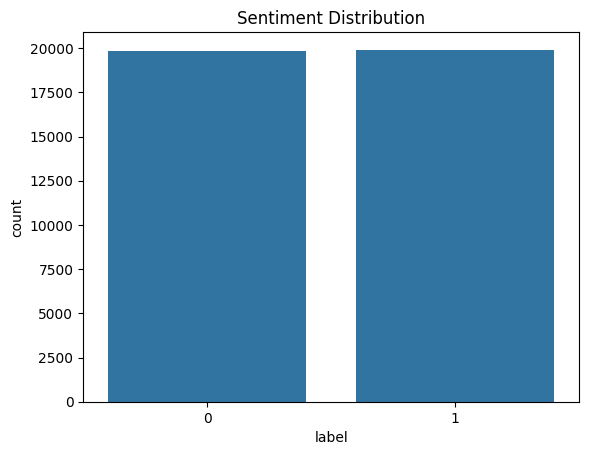

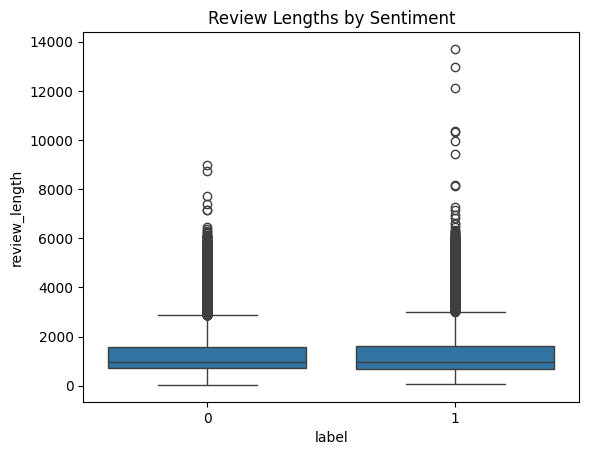

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



--- Vectorizer: CountVectorizer | Model: Logistic Regression ---
Accuracy:
0.8641913152926369
F1 Score:
0.8638829317522392
ROC AUC:
0.9323540561103151
Confusion Matrix:
[[3442  549]
 [ 530 3424]]

--- Vectorizer: CountVectorizer | Model: Bernoulli NB ---
Accuracy:
0.8495909376966646
F1 Score:
0.8477125015929655
ROC AUC:
0.9201082113561786
Confusion Matrix:
[[3424  567]
 [ 628 3326]]

--- Vectorizer: CountVectorizer | Model: SVM ---
Accuracy:
0.8352422907488987
F1 Score:
0.8349098246941606
ROC AUC:
N/A
Confusion Matrix:
[[3326  665]
 [ 644 3310]]

--- Vectorizer: CountVectorizer | Model: Random Forest ---
Accuracy:
0.8469477658904971
F1 Score:
0.8461927649886163
ROC AUC:
0.9226883718006385
Confusion Matrix:
[[3384  607]
 [ 609 3345]]

--- Vectorizer: TF-IDF | Model: Logistic Regression ---
Accuracy:
0.8853366897419761
F1 Score:
0.886167687117331
ROC AUC:
0.953672634951149
Confusion Matrix:
[[3488  503]
 [ 408 3546]]

--- Vectorizer: TF-IDF | Model: Bernoulli NB ---
Accuracy:
0.84959093

In [5]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re


#Importing sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC , LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

#For text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import os

fileis = 'movie.csv'


df = pd.read_csv(fileis)


print("First 5 rows:\n", df.head())
print("\nData shape:", df.shape)
print("\nDuplicate entries:", df.duplicated().sum())
df = df.drop_duplicates()
print("\nMissing values:\n", df.isnull().sum())
print("\nSentiment unique values:", df['label'].unique())
print("\nValue counts:\n", df['label'].value_counts())


sns.countplot(x='label', data=df)
plt.title('Sentiment Distribution')
plt.show()


df['review_length'] = df['text'].apply(len)
sns.boxplot(x='label', y='review_length', data=df)
plt.title('Review Lengths by Sentiment')
plt.show()


#Preprocessing
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

#Cleaning text
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_review'] = df['text'].apply(preprocess)

#Splitting data
X = df['cleaned_review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Feature extraction
vectorizers = {
    "CountVectorizer": CountVectorizer(max_features=10000),
    "TF-IDF": TfidfVectorizer(max_features=10000)

}

results = {}

#Training and evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Bernoulli NB": BernoulliNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier()
}

for vect_name, vect in vectorizers.items():
    X_train_vec = vect.fit_transform(X_train)
    X_test_vec = vect.transform(X_test)

    for model_name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)
        y_proba = model.predict_proba(X_test_vec)[:, 1] if hasattr(model, 'predict_proba') else None

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else 'N/A'
        cm = confusion_matrix(y_test, y_pred)

        results[(vect_name, model_name)] = {
            'Accuracy': acc,
            'F1 Score': f1,
            'ROC AUC': roc,
            'Confusion Matrix': cm
        }

#Results
for key, val in results.items():
    print(f"\n--- Vectorizer: {key[0]} | Model: {key[1]} ---")
    for metric, score in val.items():
        print(f"{metric}:\n{score}")

